<a href="https://colab.research.google.com/github/andreidm92/computer_vision_tasks/blob/main/practice/Lesson_09_SAM_advanced_lesson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Урок: Расширенные возможности SAM — Автоматическая сегментация, Классификация, Устойчивость к аугментациям


## 📍 Цели урока:
- Понять, как SAM можно использовать для **автоматической сегментации всего изображения**.
- Реализовать **присвоение классов маскам** с помощью CLIP.
- Исследовать **устойчивость SAM к аугментациям**: поворот, яркость, масштаб.
- Повторить ключевую математику: attention, positional encoding, IoU.
- Практиковать работу с OpenCV и визуализацию.



## 📘 Теория: Автоматическая сегментация в SAM

`SamAutomaticMaskGenerator` позволяет выделить **все объекты на изображении без промптов**.  
Это своего рода unsupervised instance segmentation.

**Выход модели:**
- список масок (с координатами и метаданными);
- маски накладываются друг на друга, могут пересекаться.

**Математика IoU:**

$$
IoU(A, B) = \frac{|A \cap B|}{|A \cup B|}
$$

Где $A$ и $B$ — бинарные маски объектов.


In [ ]:

# Установка SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python matplotlib torch torchvision transformers ftfy

# Импорт
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# Загрузка модели
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-wrx1arpq
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-wrx1arpq
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
--2025-05-06 12:16:00--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.48, 18.173.166.74, 18.173.166.31, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  54.7MB/s    in 37s     

2025-05-06 12:16:38 (65.5 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

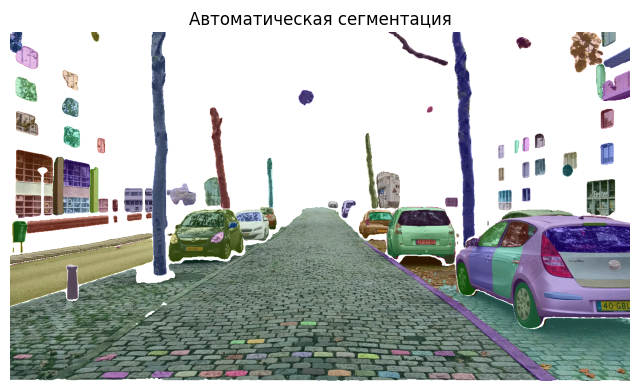

In [ ]:

# Загрузка изображения
image = cv2.imread("Street.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Автоматическая генерация масок
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)

# Визуализация
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    img = np.ones((sorted_anns[0]['segmentation'].shape[0],
                   sorted_anns[0]['segmentation'].shape[1], 4))
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    plt.imshow(img)

plt.figure(figsize=(8,8))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.title("Автоматическая сегментация")
plt.show()



## 🤖 Псевдосемантическая сегментация: SAM + CLIP

CLIP — модель, обученная связывать изображения и тексты.  
Мы можем использовать её, чтобы классифицировать **каждый сегмент**, сгенерированный SAM.

**Алгоритм:**
1. Обрезаем маской каждый сегмент из SAM.
2. Прогоняем через CLIP.
3. Сравниваем с эмбеддингами классов (например, "cat", "car", "person").
4. Назначаем наиболее близкий по косинусному расстоянию.

**Косинусное расстояние:**
$$
\cos(	heta) = \frac{A \cdot B}{\|A\| \|B\|}
$$


In [ ]:

from transformers import CLIPProcessor, CLIPModel

# Модель CLIP
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Текстовые классы
categories = ["road", "car", "tree", "building"]

# Вырезаем и классифицируем маски
for ann in masks[:5]:
    mask = ann['segmentation']
    masked_img = image.copy()
    masked_img[~mask] = 255  # белый фон

    inputs = clip_processor(text=categories, images=masked_img, return_tensors="pt", padding=True).to(device)
    outputs = clip_model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)

    pred = categories[probs.argmax()]
    print(f"Segment class: {pred}, confidence: {probs.max().item():.2f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Segment class: car, confidence: 0.97
Segment class: road, confidence: 0.95
Segment class: car, confidence: 0.99
Segment class: road, confidence: 0.41
Segment class: car, confidence: 0.98


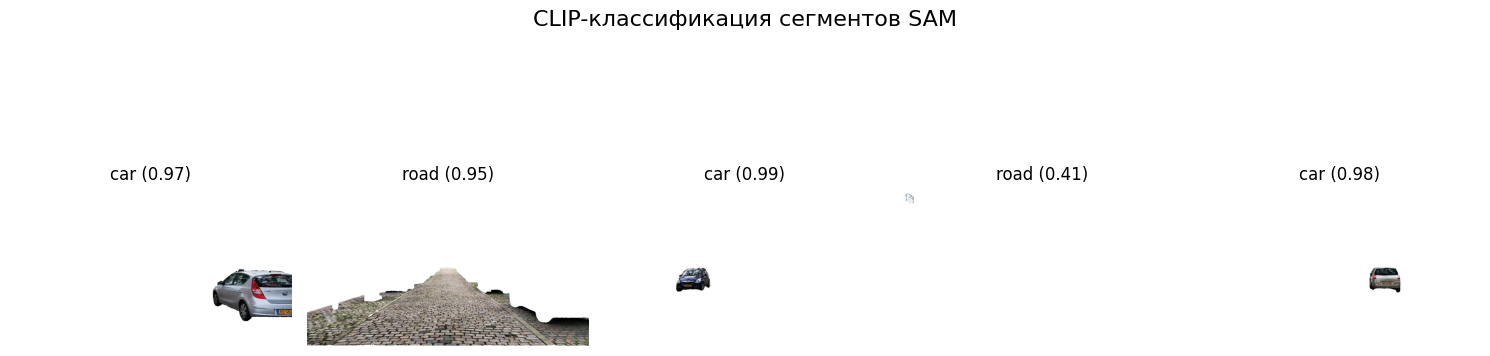

In [ ]:
import matplotlib.pyplot as plt

# Текстовые классы
categories = ["road", "car", "tree", "building"]

# Визуализируем первые 5 масок
plt.figure(figsize=(15, 5))

for i, ann in enumerate(masks[:5]):
    mask = ann['segmentation']
    masked_img = image.copy()
    masked_img[~mask] = 255  # белый фон

    # Классификация через CLIP
    inputs = clip_processor(text=categories, images=masked_img, return_tensors="pt", padding=True).to(device)
    outputs = clip_model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)

    pred_idx = probs.argmax().item()
    pred_class = categories[pred_idx]
    confidence = probs[0, pred_idx].item()

    # Визуализация
    plt.subplot(1, 5, i + 1)
    plt.imshow(masked_img)
    plt.axis("off")
    plt.title(f"{pred_class} ({confidence:.2f})")

plt.suptitle("CLIP-классификация сегментов SAM", fontsize=16)
plt.tight_layout()
plt.show()




## 🔄 Устойчивость SAM к аугментациям

### Аугментации:
- Вращение на $\pm 30^\circ$
- Изменение яркости/контраста
- Масштабирование

Мы проверим, **насколько изменятся маски**.  
Для этого вычислим **IoU между оригинальной маской и маской после аугментации**.


In [ ]:

def rotate_image(img, angle):
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(img, rot_mat, (w, h))

def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union != 0 else 0

angles = [-30, 0, 30]
ious = []

for angle in angles:
    aug_img = rotate_image(image, angle)
    masks_aug = mask_generator.generate(aug_img)
    if masks_aug and masks:
        iou = compute_iou(masks[0]['segmentation'], masks_aug[0]['segmentation'])
        ious.append(iou)
        print(f"IoU (angle={angle}°): {iou:.2f}")


IoU (angle=-30°): 0.00
IoU (angle=0°): 1.00
IoU (angle=30°): 0.23



## 🔧 Сегментация с OpenCV

OpenCV поддерживает простые методы:
- `cv2.threshold` — бинаризация
- `cv2.findContours` — выделение контуров
- `cv2.drawContours` — визуализация

Можно использовать для постобработки масок SAM, сглаживания, фильтрации шумов.


## 🔧 Зачем использовать OpenCV вместе с SAM?

Модель SAM даёт очень качественные маски объектов, но это только **первая стадия обработки изображения**.

В реальных проектах часто требуется:
- **Сгладить, очистить или упростить маски**, которые приходят из нейросетей.
- **Объединить мелкие объекты**, убрать шум.
- **Получить точные контуры объектов** — например, чтобы посчитать площадь, обвести границы или построить bounding box.
- **Подсчитать количество объектов**, найти центры масс, и т.д.

Для этих задач идеально подходит **OpenCV** — мощный инструмент для постобработки в классическом компьютерном зрении.

---

### 📚 Основные функции:

| Функция               | Назначение                                           |
|-----------------------|------------------------------------------------------|
| `cv2.threshold`       | Бинаризация: преобразует изображение в 0 и 255      |
| `cv2.findContours`    | Находит контуры объектов на бинарной маске          |
| `cv2.drawContours`    | Рисует найденные контуры поверх изображения         |
| `cv2.morphologyEx`    | Морфология: удаление шума, сглаживание, замыкание дыр |

---

### 🧩 Пример типичного пайплайна:

1. Преобразовать маску SAM в `uint8`:  
   ```python
   binary = (mask * 255).astype(np.uint8)



### 🧼 Очистка шума

```python
kernel = np.ones((3, 3), np.uint8)
clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

### 🧼 Найти контуры
contours, _ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

### 🧼 Нарисовать контуры
result = image.copy()
cv2.drawContours(result, contours, -1, (0, 255, 0), 2)



## 📐 Линейная алгебра: собственные значения и векторы

### Что это:
Для матрицы $A$ вектор $v$ и число $\lambda$ такие, что:

$$
A v = \lambda v
$$

- $v$ — собственный вектор,
- $\lambda$ — собственное значение.

### Зачем это нужно:
- В PCA для понижения размерности — сохраняются направления с наибольшей дисперсией.
- В анализе stability, динамики систем (например, автопилоты, роботы).
- В нейросетях: спектральный анализ слоёв, Hessian, Jacobian.

### Пример:
Матрица ковариации:

$$
\Sigma = \frac{1}{n} X^T X
$$

Её собственные векторы — главные компоненты (PCA).


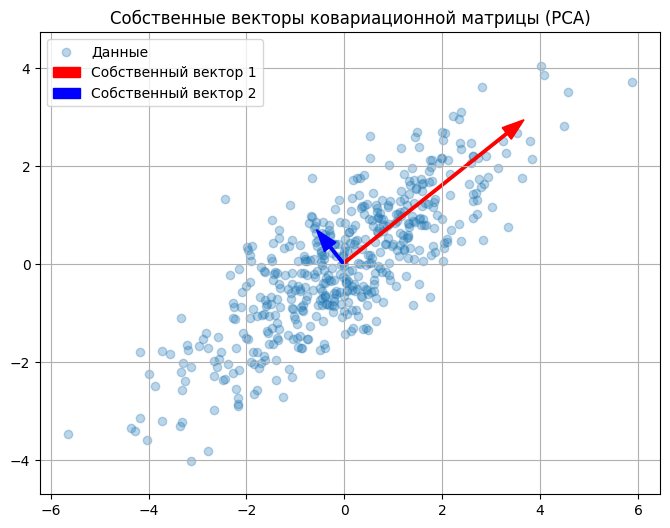

In [ ]:
# Повторный запуск после сброса среды

import numpy as np
import matplotlib.pyplot as plt

# Генерация искусственных 2D данных
np.random.seed(42)
mean = [0, 0]
cov = [[3, 2], [2, 2]]  # ковариационная матрица (анисотропное распределение)
X = np.random.multivariate_normal(mean, cov, 500)

# Расчёт ковариационной матрицы вручную
X_centered = X - np.mean(X, axis=0)
cov_matrix = np.cov(X_centered, rowvar=False)

# Собственные значения и векторы
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Масштабируем векторы по длине λ для визуализации
origin = np.mean(X, axis=0)
scaled_vectors = eigenvectors * eigenvalues.reshape(1, -1)

# Визуализация
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.3, label='Данные')
for i in range(2):
    vec = scaled_vectors[:, i]
    plt.arrow(origin[0], origin[1], vec[0], vec[1],
              color='red' if i == 0 else 'blue',
              width=0.05, head_width=0.3, label=f'Собственный вектор {i+1}')

plt.title("Собственные векторы ковариационной матрицы (PCA)")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


## 📊 Ковариационная матрица и анизотропное распределение

### 📌 Что такое ковариационная матрица?

Ковариационная матрица описывает, как связаны между собой переменные в многомерных данных.  
Если у нас есть два признака \( x \) и \( y \), то ковариационная матрица имеет вид:

$$
\Sigma =
\begin{bmatrix}
\text{Var}(x) & \text{Cov}(x, y) \\\\
\text{Cov}(y, x) & \text{Var}(y)
\end{bmatrix}
$$

- \( \text{Var}(x) \), \( \text{Var}(y) \): дисперсия (разброс значений) по осям \( x \), \( y \)
- \( \text{Cov}(x, y) \): ковариация между переменными \( x \) и \( y \)

---

### 🔁 Интерпретация ковариации:

- \( \text{Cov}(x, y) > 0 \): переменные растут вместе (направлены в одну сторону)
- \( \text{Cov}(x, y) < 0 \): одна растёт, другая убывает
- \( \text{Cov}(x, y) = 0 \): переменные статистически независимы

---

### 🧠 Изотропное и анизотропное распределения

#### 🔸 Изотропное:
- Вид: круг или сфера
- Свойства: одинаковая дисперсия по всем направлениям
- Ковариационная матрица близка к диагональной

#### 🔸 Анизотропное:
- Вид: вытянутый эллипс
- Свойства: разная дисперсия по осям, есть направленность
- Ковариационная матрица содержит сильные вне диагональные элементы

---

### 🧩 Пример ковариационной матрицы:

$$
\Sigma =
\begin{bmatrix}
3 & 2 \\\\
2 & 2
\end{bmatrix}
$$

- Дисперсия по оси \( x \): 3  
- Дисперсия по оси \( y \): 2  
- Ковариация между \( x \) и \( y \): 2

Такое распределение будет **анизотропным** — вытянутым вдоль определённого направления в пространстве.

---

### 📐 Связь с собственными векторами

- Собственные векторы ковариационной матрицы указывают **главные оси дисперсии**.
- Собственные значения показывают, **сколько дисперсии содержится вдоль каждого направления**.
- Это основа метода **PCA (Principal Component Analysis)**: снижение размерности путём проекции на главные оси.


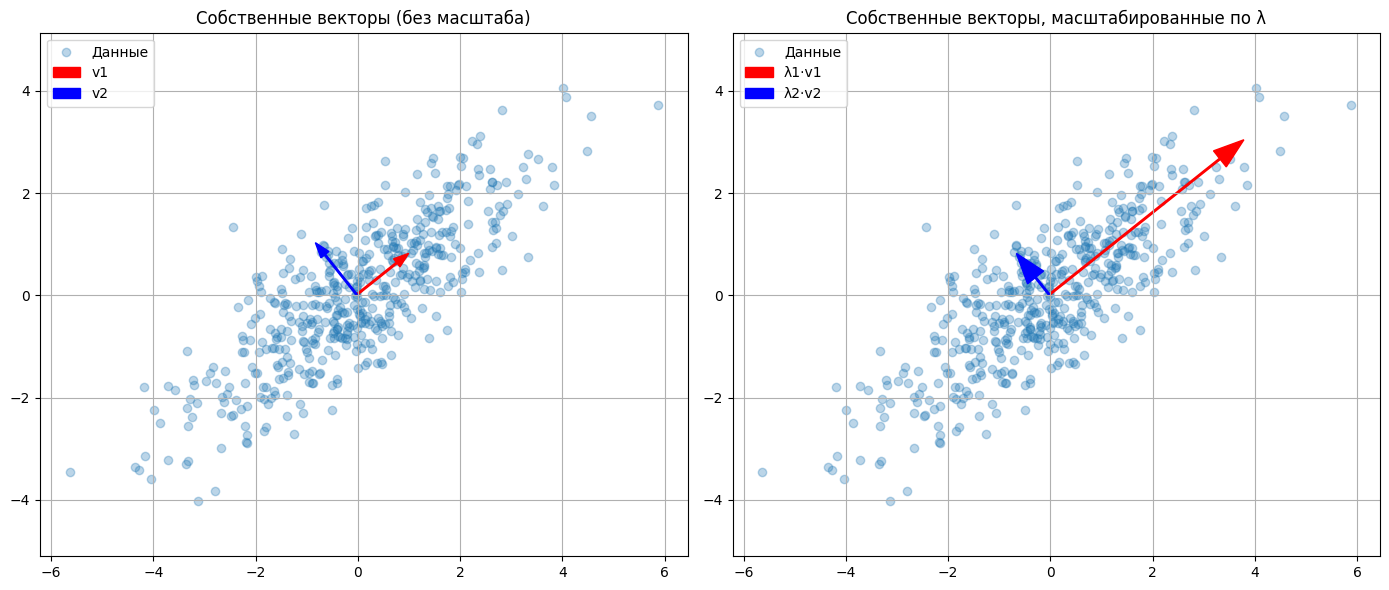

In [ ]:
# Повтор запуска после сброса среды

import numpy as np
import matplotlib.pyplot as plt

# Генерация данных
np.random.seed(42)
mean = [0, 0]
cov = [[3, 2], [2, 2]]
X = np.random.multivariate_normal(mean, cov, 500)

# Центрирование и ковариационная матрица
X_centered = X - np.mean(X, axis=0)
cov_matrix = np.cov(X_centered, rowvar=False)

# Собственные значения и векторы
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
origin = np.mean(X, axis=0)

# Без масштабирования
plain_vectors = eigenvectors

# Визуализация: с масштабом и без
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# --- Без масштабирования ---
axs[0].scatter(X[:, 0], X[:, 1], alpha=0.3, label="Данные")
for i in range(2):
    vec = plain_vectors[:, i]
    axs[0].arrow(origin[0], origin[1], vec[0], vec[1],
                 color='red' if i == 0 else 'blue',
                 width=0.03, head_width=0.2, label=f'v{i+1}')
axs[0].set_title("Собственные векторы (без масштаба)")
axs[0].axis("equal")
axs[0].legend()
axs[0].grid(True)

# --- С масштабом ---
scaled_vectors = eigenvectors * eigenvalues.reshape(1, -1)
axs[1].scatter(X[:, 0], X[:, 1], alpha=0.3, label="Данные")
for i in range(2):
    vec = scaled_vectors[:, i]
    axs[1].arrow(origin[0], origin[1], vec[0], vec[1],
                 color='red' if i == 0 else 'blue',
                 width=0.03, head_width=0.4, label=f'λ{i+1}·v{i+1}')
axs[1].set_title("Собственные векторы, масштабированные по λ")
axs[1].axis("equal")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()
